In [1]:
using PerlaTonettiWaugh, Plots, BenchmarkTools

In [2]:
z_min = 0.0 
z_max = 5.0
M = 1000
z_grid = range(z_min, stop = z_max, length = M) # Since we only care about the grid. 

# Time
tstops_min_Δ_val = 1e-3 # minimum distance between tstops to be used for DE solvers.
# Define common objects. 
d_0 = 5
d_T = 2.3701
params = (ρ = 0.02, σ = 4.2508, N = 10, θ = 5.1269, γ = 1.00, κ = 0.013, ζ = 1, η = 0, Theta = 1, χ = 1/(2.1868), υ = 0.0593, μ = 0, δ = 0.053, d = 2.3701) # Baselines per Jesse. 
stationary_sol = stationary_numerical(params, z_grid) # solution at t = T
println("g = $(stationary_sol.g), z_hat = $(stationary_sol.z_hat), Ω = $(stationary_sol.Ω)")

g = 0.02041988055463095, z_hat = 1.4257125354879605, Ω = 1.0365494651167921


Set ups and test f! first to see if residuals are reasonable at `T`

In [3]:
# solve for stationary solution at t = 0
params_0 = merge(params, (d = d_0,)) # parameters to be used at t = 0
params_T = merge(params, (d = d_T,)) # parameters to be used at t = T

stationary_sol_0 = stationary_numerical(params_0, z_grid) # solution at t = 0
Ω_0 = stationary_sol_0.Ω

1.623572184886303

In [4]:
T = sqrt(2*(log(Ω_0) - log(stationary_sol.Ω)) / params.δ) 
Ω(t) = stationary_sol.Ω  # constant Ω

# get settings
settings = (z = z_grid, tstops = 0:1e-3:T, Δ_E = 1e-04)
Δ_E = 1e-4
E(t) = (log(Ω(t+Δ_E)) - log(Ω(t-Δ_E)))/(2*Δ_E) + params.δ

E (generic function with 1 method)

## Testing and profiling the core function

In [5]:
# #Testing the f!
du = zeros(M)
u = [stationary_sol.v_tilde; stationary_sol.g; stationary_sol.z_hat]
resid = similar(u)
du = zeros(M+2)
t = T
f! = solve_dynamics(params_T, stationary_sol, settings, T, Ω, E; stopwithf! = true)
@btime f!($resid,$du,$u,[ ],$t)

  33.042 μs (129 allocations: 205.41 KiB)


4.293049471471022e-9

## Solving the Full Problem with Dynamics
Now let's solve the problem and draw the plots!

In [6]:
# solve the dynamics!
@time solved = solve_dynamics(params_T, stationary_sol, settings, T, Ω, E; detailed_solution = true)
v_t0 = solved.sol.u[1][1:M]
v0 = solved.results[:v_0]
# save v0 and v_hat_t0
v_hat_t0 = map(z -> exp((params.σ-1)*z), z_grid) .* v_t0;

solved = solved.results

 11.401574 seconds (34.47 M allocations: 12.540 GiB, 8.85% gc time)


,t,g,z_hat,Ω,E,v_0,L_tilde,entry_residual,λ_ii,c,S,z_bar,π_min,log_M,U
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0204199,1.42571,1.03655,0.053,1.1868,0.200431,5.24047e-12,0.781323,0.987584,0.058475,3.62542,0.0678434,0.0,0.845175
2,0.001,0.0204199,1.42571,1.03655,0.053,1.1868,0.200431,5.1894e-12,0.781323,0.987584,0.058475,3.62542,0.0678434,2.04199e-5,0.84502
3,0.002,0.0204199,1.42571,1.03655,0.053,1.1868,0.200431,5.13745e-12,0.781323,0.987584,0.058475,3.62542,0.0678434,4.08398e-5,0.844864
4,0.003,0.0204199,1.42571,1.03655,0.053,1.1868,0.200431,5.08549e-12,0.781323,0.987584,0.058475,3.62542,0.0678434,6.12596e-5,0.844708
5,0.004,0.0204199,1.42571,1.03655,0.053,1.1868,0.200431,5.03397e-12,0.781323,0.987584,0.058475,3.62542,0.0678434,8.16795e-5,0.844553
6,0.005,0.0204199,1.42571,1.03655,0.053,1.1868,0.200431,4.98246e-12,0.781323,0.987584,0.058475,3.62542,0.0678434,0.000102099,0.844397
7,0.006,0.0204199,1.42571,1.03655,0.053,1.1868,0.200431,4.93006e-12,0.781323,0.987584,0.058475,3.62542,0.0678434,0.000122519,0.844241
8,0.007,0.0204199,1.42571,1.03655,0.053,1.1868,0.200431,4.87854e-12,0.781323,0.987584,0.058475,3.62542,0.0678434,0.000142939,0.844086
9,0.008,0.0204199,1.42571,1.03655,0.053,1.1868,0.200431,4.82703e-12,0.781323,0.987584,0.058475,3.62542,0.0678434,0.000163359,0.84393


## Primary Plots

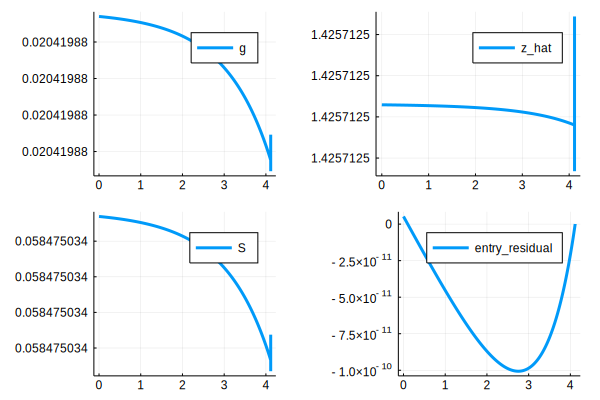

In [7]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2))

## Static Equations

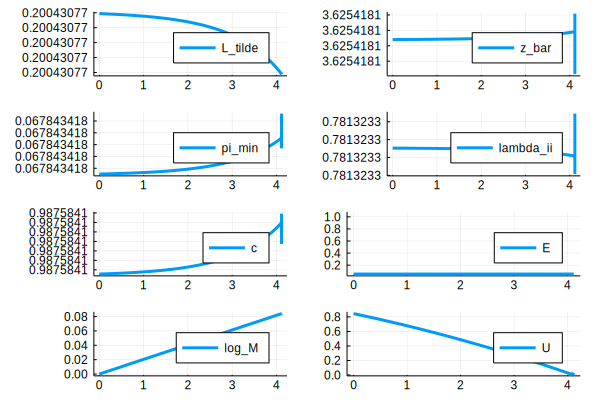

In [8]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_min, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(z_grid, v_hat_t0, label = "v_hat at t = 0", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, layout=(4,2))

In [9]:
# Can examine the returned data with the Voyager and/or Vegalite
using DataVoyager, VegaLite
solved |> Voyager()
#solved |> @vlplot(:line, x = :t, y = :g, width=400, height=400)

ErrorException: Path contained unexpected character